Stochastic Variational Bayes - example nonlinear model
==============================================

This notebook implements stochastic variational Bayes for a nonlinear model. The model we will use is a bi-exponential model, i.e. we will assume our data reflects a time-dependent signal of the following form:

$$S_{true}(t) = A_1 e^{-R_1t} + A_2 e^{-R_2t}$$

However the actual time dependent signal $S(t)$ will be affected by additive Gaussian noise, so will have the distribution:

$$P(S(t)) = \frac{\sqrt{\beta}}{\sqrt{2\pi}} \exp{\bigg(-\frac{\beta}{2} (S(t) - S_{true}(t))^2}\bigg)$$

Given $S(t)$ our aim will be to infer the values of $A_1$, $A_2$, $R_1$, $R_2$ and $\beta$.

Here's how we can generate some sample data from this model in Python:

In [1]:
import numpy as np
%matplotlib inline
# Ground truth parameters
# We infer the precision, BETA, but it is useful to
# derive the variance and standard deviation from it
A1_TRUTH = 10.0
A2_TRUTH = 10.0
R1_TRUTH = 10.0
R2_TRUTH = 1.0
BETA_TRUTH = 1.0
VAR_TRUTH = 1/BETA_TRUTH
STD_TRUTH = np.sqrt(VAR_TRUTH)

# Observed data samples are generated by Numpy from the ground truth
# Gaussian distribution. Reducing the number of samples should make
# the inference less 'confident' - i.e. the output variances for
# MU and BETA will increase
N = 200
T = np.linspace(0, 5, N)


DATA_CLEAN = A1_TRUTH * np.exp(-R1_TRUTH * T) + A2_TRUTH * np.exp(-R2_TRUTH*T)
DATA = DATA_CLEAN + np.random.normal(0, STD_TRUTH, [N])
print("Data samples are:")
print(DATA)

Data samples are:
[ 2.03620472e+01  1.76781216e+01  1.39776282e+01  1.10712623e+01
  1.16523916e+01  1.30277908e+01  1.25537193e+01  1.01704583e+01
  7.96354263e+00  9.20085070e+00  8.75754246e+00  9.35617879e+00
  7.89357752e+00  7.53311329e+00  5.91293872e+00  5.24376529e+00
  6.28336297e+00  6.71847155e+00  5.71790066e+00  5.25259236e+00
  6.56513068e+00  6.95087490e+00  6.12893516e+00  7.12010747e+00
  6.39054434e+00  3.36110237e+00  5.24067202e+00  5.17919296e+00
  4.53724675e+00  4.20705702e+00  4.31729696e+00  2.78275598e+00
  5.56552827e+00  5.43811444e+00  3.58719833e+00  4.85273364e+00
  4.53756383e+00  2.42757610e+00  3.13918933e+00  2.63059348e+00
  2.03080086e+00  2.53277044e+00  2.79351027e+00  4.18524491e+00
  2.84583052e+00  2.47523917e+00  2.80880143e+00  2.88411467e+00
  4.35590416e+00  2.38959304e+00  3.70478916e+00  1.26115357e+00
  3.53994629e+00  2.26371690e+00  3.67565582e+00  1.81290846e+00
  4.87808803e-01  1.71551353e+00  2.81804463e+00  1.65500374e+00
  2.051

We can plot this data to illustrate the true signal (green line) and the measured data (red crosses):

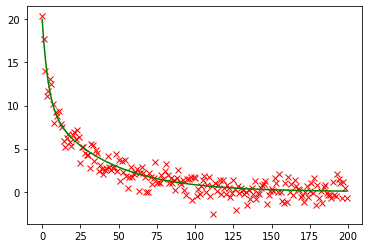

In [2]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(DATA, "rx")
plt.plot(DATA_CLEAN, "g")

As with the single Gaussian example we will use a multivariate normal distribution as our prior and approximate posterior distributions. 

One difference here is that we will choose to infer the log of the decay rate parameters $R_1$ and $R_2$. This is because if these parameters are allowed to become negative the model prediction will become an exponential growth and can easily lead to numerical errors.

We will still choose our priors to be relatively uninformative as follows:


In [3]:
a0 = 1.0
v0 = 100000.0
r0 = 0.0
u0 = 10.0
b0 = 0.0
w0 = 10.0
print("Priors: Amplitude mean=%f, variance=%f" % (a0, v0))
print("        Log decay rate mean=%f, variance=%f" % (r0, u0))
print("        Log noise variance mean=%f, variance=%f" % (b0, w0))

Priors: Amplitude mean=1.000000, variance=100000.000000
        Log decay rate mean=0.000000, variance=10.000000
        Log noise variance mean=0.000000, variance=10.000000


The posterior will be defined in the same way as for the single Gaussian example, however we need to account for the increased number of parameters we are inferring. We will initialize the posterior with the prior values but with reduced initial variance to prevent problems with generating a representative posterior sample. Remember that the decay rates (and the noise) are being inferred as their log-values so the prior mean of 0 translates into a value of 1.

The code to generate a posterior sample is unchanged except for the number of parameters.

In calculating the reconstruction cost we need to calculate the log likelihood of the data given a set of model parameters. We do this by observing that any difference between the biexponential model prediction (given these parameters) and the actual noisy data must be a result of the Gaussian noise - hence the likelihood is simply the likelihood of drawing these differences from the Gaussian noise distribution:

$$\log P(\textbf{y} | A_1; A_2; r_1; r_2; \beta) = \frac{1}{2} \bigg( N \log \beta - \sum{\frac{(y_n - M_n)^2}{\beta}}\bigg)$$

Here $M_n$ is the model prediction for the nth data point which is calculated by evaluating the biexponential model for the given parameters $A_1$, $A_2$, $r_1$ and $r_2$.

For the latent loss we will again use the analytic expression for the K-L divergence of two MVN distributions with a slight modification to the previous code to account for the different number of parameters (5 vs 2)

In [4]:
import tensorflow as tf

# Number of parameters - 4 for the biexponential + noise
NUM_PARAMS = 4 + 1

data = tf.constant(DATA, dtype=tf.float32)
prior_means = tf.constant([a0, r0, a0, r0, b0], dtype=tf.float32)
prior_covariance = tf.linalg.diag(tf.constant([v0, u0, v0, u0, w0], dtype=tf.float32))

post_means_init = prior_means
post_covariance_init = np.identity(NUM_PARAMS, dtype=np.float32)

chol_off_diag = tf.Variable(np.zeros(post_covariance_init.shape), dtype=tf.float32)
# Comment in this line if you do NOT want to infer parameter covariances
#chol_off_diag = tf.constant([[0, 0], [0, 0]], dtype=tf.float32)
chol_log_diag = tf.Variable(tf.math.log(tf.linalg.diag_part(post_covariance_init)), dtype=tf.float32)

post_means = tf.Variable(post_means_init, dtype=tf.float32)

t = tf.reshape(tf.constant(T, dtype=tf.float32), [1, -1])



def cost_fun():

    chol_diag = tf.linalg.diag(tf.math.sqrt(tf.math.exp(chol_log_diag)))
    post_covariance_chol = tf.math.add(chol_diag, tf.linalg.band_part(chol_off_diag, -1, 0))

    post_covariance = tf.matmul(tf.transpose(post_covariance_chol), post_covariance_chol)

    S=5
    N=200

# eps is a sample from a Gaussian with mean 0 and variance 1
    eps = tf.random.normal((NUM_PARAMS, S), 0, 1, dtype=tf.float32)

# Start off each sample with the current posterior mean
# post_samples is now a tensor of shape [NUM_PARAMS, n_samples]
    samples = tf.tile(tf.reshape(post_means, [NUM_PARAMS, 1]), [1, S])

# Now add the random sample scaled by the covariance
    post_samples = tf.add(samples, tf.matmul(post_covariance_chol, eps))

    a1 = tf.reshape(post_samples[0], [-1, 1])
    r1 = tf.math.exp(tf.reshape(post_samples[1], [-1, 1]))
    a2 = tf.reshape(post_samples[2], [-1, 1])
    r2 = tf.math.exp(tf.reshape(post_samples[3], [-1, 1]))

# Get the current estimate of the noise variance remembering that
# we are inferring the log of the noise precision, beta
    log_noise_var = -post_samples[4]
    noise_var = tf.math.exp(log_noise_var)

# Each sample value predicts the full set of values in the data sample.
# For our constant-signal model, the prediction is simply a set of 
# constant values. The prediction tensor will have shape [S, N]
# where S is the sample size and N is the number of data values
    

    prediction = a1*tf.math.exp(-r1*t) + a2*tf.exp(-r2*t)
    diff = tf.reshape(data, [1, -1]) - prediction

# To calculate the likelihood we need the sum of the squared difference between the data  
# and the prediction. This gives a value for each posterior sample so has shape [S]
    sum_square_diff = tf.reduce_sum(tf.math.square(diff), axis=1)

# Now we calculate the likelihood for each posterior sample (shape [S])
# Note that we are ignoring constant factors such as 2*PI here as they 
# are just an fixed offset and do not affect the optimization 
    log_likelihood = 0.5 * (-log_noise_var * tf.cast(N,dtype=tf.float32) - sum_square_diff / noise_var)

# Finally to evaluate the expectation value we take the mean across all the posterior
# samples. The negative of this is the reconstruction loss
    reconstr_loss = -tf.reduce_mean(log_likelihood)

    C = post_covariance
    C0 = prior_covariance
    #print("is this the problem? 1")
    #print(tf.linalg.det(C0))
    C0_inv = tf.linalg.inv(C0)
    #print("is this the problem? 2")

# m - m0 as row and column vectors
    m_minus_m0 = tf.reshape(tf.subtract(post_means, prior_means), [-1, 1])
    m_minus_m0_T = tf.reshape(tf.subtract(post_means, prior_means), [1, -1])

    term1 = tf.linalg.trace(tf.matmul(C0_inv, C))
    term2 = -tf.math.log(tf.linalg.det(C) / tf.linalg.det(C0))

# Size of the MVN distribution
    term3 = -NUM_PARAMS
    term4 = tf.matmul(tf.matmul(m_minus_m0_T, C0_inv), m_minus_m0)
          
    latent_loss = 0.5 * (term1 + term2 + term3 + term4)

    #cost = reconstr_loss + latent_loss
    cost=reconstr_loss

    return cost




2023-03-19 17:07:51.945965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38284 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-03-19 17:07:51.947931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38284 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:44:00.0, compute capability: 8.0
2023-03-19 17:07:51.949520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38284 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:84:00.0, compute capability: 8.0
2023-03-19 17:07:51.951196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38284 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

Finally we ask TensorFlow to minimise the total cost iteratively:

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
#minimizer = optimizer.minimize(cost)
#sess.run(tf.global_variables_initializer())
from tqdm.notebook import tqdm_notebook

cost_history = []
for epoch in tqdm_notebook(range(5000), desc="Epoch:"):
    #sess.run(minimizer)

    optimizer.minimize(cost_fun,var_list=[chol_off_diag,chol_log_diag,post_means])
    #print(float(cost_fun()))
    cost_history.append(float(cost_fun()))
    #print("Epoch %i: posterior means=%s" % (epoch+1, post_means))

Epoch::   0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
final_means = post_means

chol_diag = tf.linalg.diag(tf.math.sqrt(tf.math.exp(chol_log_diag)))
post_covariance_chol = tf.add(chol_diag, tf.linalg.band_part(chol_off_diag, -1, 0))

post_covariance = tf.matmul(tf.transpose(post_covariance_chol), post_covariance_chol)

final_covariance = post_covariance
print("Estimate for amp1: %f (variance: %f)" % (final_means[0], final_covariance[0, 0]))
print("Estimate for amp2: %f (variance: %f)" % (final_means[2], final_covariance[0, 0]))
print("Estimate for r1: %f" % (np.exp(final_means[1]),))
print("Estimate for r2: %f" % (np.exp(final_means[3]),))
print("Estimate for beta (noise): %f" % np.exp(-final_means[4]))

Estimate for amp1: 10.243862 (variance: 0.000000)
Estimate for amp2: 9.581695 (variance: 0.000000)
Estimate for r1: 1.075554
Estimate for r2: 11.576426
Estimate for beta (noise): 0.912233


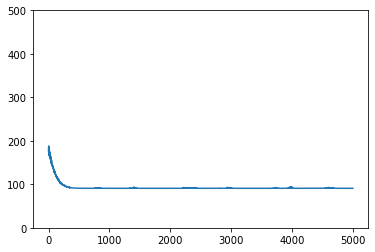

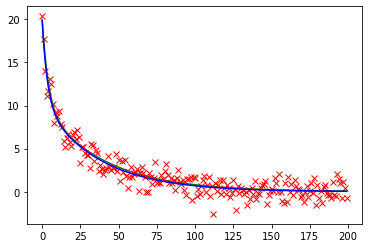

In [10]:
plt.figure()
plt.plot(cost_history)
plt.ylim(0, 500)

plt.figure()
plt.plot(DATA_CLEAN, 'g')
plt.plot(DATA, 'rx')
S=5
eps = tf.random.normal((NUM_PARAMS, S), 0, 1, dtype=tf.float32)

samples = tf.tile(tf.reshape(post_means, [NUM_PARAMS, 1]), [1, S])

# Now add the random sample scaled by the covariance
post_samples = tf.add(samples, tf.matmul(post_covariance_chol, eps))

a1 = tf.reshape(post_samples[0], [-1, 1])
r1 = tf.math.exp(tf.reshape(post_samples[1], [-1, 1]))
a2 = tf.reshape(post_samples[2], [-1, 1])
r2 = tf.math.exp(tf.reshape(post_samples[3], [-1, 1]))

# Get the current estimate of the noise variance remembering that
# we are inferring the log of the noise precision, beta
log_noise_var = -post_samples[4]
noise_var = tf.math.exp(log_noise_var)

# Each sample value predicts the full set of values in the data sample.
# For our constant-signal model, the prediction is simply a set of 
# constant values. The prediction tensor will have shape [S, N]
# where S is the sample size and N is the number of data values
t = tf.reshape(tf.constant(T, dtype=tf.float32), [1, -1])
prediction = a1*tf.math.exp(-r1*t) + a2*tf.exp(-r2*t)

plt.plot(prediction[0], 'b')
plt.show()